# Setup 🏗️


In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from random import randrange




In [2]:
viscos = 1/5200

# load RANS data created by rans.m (which can be downloaded)
# load DNS data
DNS_mean  = np.genfromtxt("LM_Channel_5200_mean_prof.dat",comments="%").transpose()
y_DNS     = DNS_mean[0]
yplus_DNS = DNS_mean[1]
u_DNS     = DNS_mean[2]
dudy_DNS  = np.gradient(u_DNS,y_DNS)

DNS_stress = np.genfromtxt("LM_Channel_5200_vel_fluc_prof.dat",comments="%").transpose()

uu_DNS = DNS_stress[2]
vv_DNS = DNS_stress[3]
ww_DNS = DNS_stress[4]
uv_DNS = DNS_stress[5]
uw_DNS = DNS_stress[6]
vw_DNS = DNS_stress[7]
k_DNS  = 0.5*(uu_DNS+vv_DNS+ww_DNS)

DNS_RSTE = np.genfromtxt("LM_Channel_5200_RSTE_k_prof.dat",comments="%")

eps_DNS = DNS_RSTE[:,7]/viscos # it is scaled with ustar**4/viscos

# fix wall
eps_DNS[0]=eps_DNS[1]

# load data from k-omega RANS
data  = np.loadtxt('y_u_k_om_uv_5200-RANS-code.txt').transpose()
y     = data[0]
u     = data[1]
k     = data[2]
om    = data[3]
diss1 = 0.09*k*om
ustar = (viscos*u[0]/y[0])**0.5
yplus = y*ustar/viscos

# dont train on, uu, vv, ww, uv, uw, vw 
# Maybe mixed terms are ok (just not uu,vv,ww)

#-----------------Data_manipulation--------------------

# Delete first value for all interesting data
uv_DNS    = np.delete(uv_DNS, 0)
vv_DNS    = np.delete(vv_DNS, 0)
ww_DNS    = np.delete(ww_DNS, 0)
uw_DNS    = np.delete(uw_DNS,0)
vw_DNS    = np.delete(vw_DNS,0)
k_DNS     = np.delete(k_DNS, 0)
eps_DNS   = np.delete(eps_DNS, 0)
dudy_DNS  = np.delete(dudy_DNS, 0)
yplus_DNS = np.delete(yplus_DNS,0)
uu_DNS    = np.delete(uu_DNS,0)
y_DNS     = np.delete(y_DNS,0)
u_DNS     = np.delete(u_DNS,0)

# Calculate ny_t and time-scale tau
viscous_t = k_DNS**2/eps_DNS 
tau       = viscous_t/abs(uv_DNS)

# Calculate c_1, c_2, & c_3 of the Non-linear Eddy Viscosity Model
# Array for storing c_1, c_2, & c_3
c_0 = -2*(ww_DNS/k_DNS - 2/3)/(tau**2*dudy_DNS**2)
c_2 = 2*((ww_DNS/k_DNS - 2/3) + (uu_DNS/k_DNS - 2/3))/(tau**2*dudy_DNS**2)

c = np.array([c_0,c_2])

dudy_squared_DNS = (dudy_DNS**2).reshape(-1,1)

#TODO ML using PyTorch to estimate c_1, c_2, & c_3


Setting up input and output as tensors 

In [3]:

def reshape_those_fuckers(*args):
    return [arg.reshape(-1,1) for arg in args]



X = StandardScaler().fit_transform(dudy_squared_DNS)

# transpose the target vector to make it a column vector  
y = c.transpose()

#tau, dudy, k, uu, vv, ww, yplus_DNS
test_var = np.concatenate((reshape_those_fuckers(tau,dudy_DNS,k_DNS,uu_DNS,vv_DNS,ww_DNS,yplus_DNS)),axis=1)

# split the feature matrix and target vector into training and validation sets
# test_size=0.2 means we reserve 20% of the data for validation
# random_state=42 is a fixed seed for the random number generator, ensuring reproducibility

random_state = randrange(100)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state= random_state)
X_train, X_val, test_var_train, test_var_val = train_test_split(X, test_var, test_size=0.2, random_state= random_state)

# convert the numpy arrays to PyTorch tensors with float32 data type
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# create PyTorch datasets and dataloaders for the training and validation sets
# a TensorDataset wraps the feature and target tensors into a single dataset
# a DataLoader loads the data in batches and shuffles the batches if shuffle=True
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
print(test_var_val)

[[5.55628356e-01 4.19647422e+01 4.32526789e+00 ... 1.25755821e+00
  2.15314238e+00 3.19879688e+02]
 [2.96907358e+00 4.80936301e+00 1.58485010e+00 ... 6.71427871e-01
  8.25222708e-01 3.21384383e+03]
 [2.15112521e+01 4.95909106e-01 8.75260218e-01 ... 4.79021513e-01
  4.86118915e-01 5.01520143e+03]
 ...
 [2.09555303e-01 1.13290280e+02 4.75289393e+00 ... 1.27306292e+00
  2.57159426e+00 1.08931648e+02]
 [1.14652650e-01 2.24543896e+02 5.07466252e+00 ... 1.15147713e+00
  2.75260947e+00 5.47306629e+01]
 [3.25692529e+00 4.24162293e+00 1.41463351e+00 ... 6.20350319e-01
  7.38939490e-01 3.50434215e+03]]


Let's set up a neural network:

In [5]:
class ThePredictionMachine(nn.Module):

    def __init__(self):
        
        super(ThePredictionMachine, self).__init__()

        self.input   = nn.Linear(1, 50)     
        self.hidden1 = nn.Linear(50, 25)    
        self.hidden2 = nn.Linear(25, 2)     

    def forward(self, x):
        x = nn.functional.relu(self.input(x))
        x = nn.functional.relu(self.hidden1(x))
        x = self.hidden2(x)
        return x


In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    print(f"Avg loss: {test_loss:>8f} \n")

In [34]:
# Instantiate a neural network
neural_net = ThePredictionMachine()

# Set up hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 1000

# Initialize the loss function
loss_fn = nn.MSELoss()

# Choose loss function, check out https://pytorch.org/docs/stable/optim.html for more info
# In this case we choose Stocastic Gradient Descent
optimizer = torch.optim.SGD(neural_net.parameters(), lr=learning_rate)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, neural_net, loss_fn, optimizer)
    test_loop(val_loader, neural_net, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Avg loss: 0.020681 

Epoch 2
-------------------------------
Avg loss: 0.018970 

Epoch 3
-------------------------------
Avg loss: 0.017408 

Epoch 4
-------------------------------
Avg loss: 0.015929 

Epoch 5
-------------------------------
Avg loss: 0.014632 

Epoch 6
-------------------------------
Avg loss: 0.013419 

Epoch 7
-------------------------------
Avg loss: 0.012336 

Epoch 8
-------------------------------
Avg loss: 0.011345 

Epoch 9
-------------------------------
Avg loss: 0.010437 

Epoch 10
-------------------------------
Avg loss: 0.009605 

Epoch 11
-------------------------------
Avg loss: 0.008842 

Epoch 12
-------------------------------
Avg loss: 0.008142 

Epoch 13
-------------------------------
Avg loss: 0.007500 

Epoch 14
-------------------------------
Avg loss: 0.006911 

Epoch 15
-------------------------------
Avg loss: 0.006370 

Epoch 16
-------------------------------
Avg loss: 0.005873 

Epoch 17
--------

In [35]:
preds = neural_net(X_val_tensor)

In [36]:
print(preds)


tensor([[ 0.0017,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0017,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0017,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0010,  0.0018],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0012,  0.0015],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0016,  0.0010],
        [ 0.0018,  0.0008],
        [ 0.0017,  0.0008],
        [ 0.0018,  0.0008],
        [-0.0205,  0.0796],
        [ 0.0018,  0.0008],
        [ 0.0017,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0018,  0.0008],
        [ 0.0017,  0.0008],
        [ 0.0014,  0.0013],
        [ 0.0018,  0.0008],
        [ 0.0018,  0

In [37]:
print(y_val_tensor)

tensor([[6.2119e-04, 1.3829e-03],
        [1.4318e-03, 2.3836e-03],
        [1.9555e-03, 2.0980e-03],
        [1.7245e-03, 2.3779e-03],
        [1.7698e-03, 2.3615e-03],
        [1.4045e-03, 2.4021e-03],
        [1.4917e-03, 2.3954e-03],
        [1.9241e-03, 2.1602e-03],
        [7.0555e-04, 1.4818e-03],
        [8.7382e-04, 1.7072e-03],
        [1.7842e-03, 2.3530e-03],
        [5.7670e-04, 1.3422e-03],
        [1.8017e-03, 2.3353e-03],
        [1.2754e-03, 2.2986e-03],
        [3.9698e-04, 1.4340e-03],
        [1.3512e-03, 2.4236e-03],
        [1.3848e-03, 2.4377e-03],
        [4.1102e-04, 1.4597e-03],
        [1.3725e-03, 2.4423e-03],
        [1.3786e-03, 2.4381e-03],
        [1.9749e-03, 2.1433e-03],
        [8.9307e-04, 1.7338e-03],
        [1.8744e-03, 2.2639e-03],
        [4.7651e-04, 1.3561e-03],
        [1.3672e-03, 2.4374e-03],
        [7.1624e-04, 1.4953e-03],
        [1.3986e-03, 2.4428e-03],
        [2.4052e-05, 4.4559e-05],
        [1.4247e-03, 2.3812e-03],
        [8.048

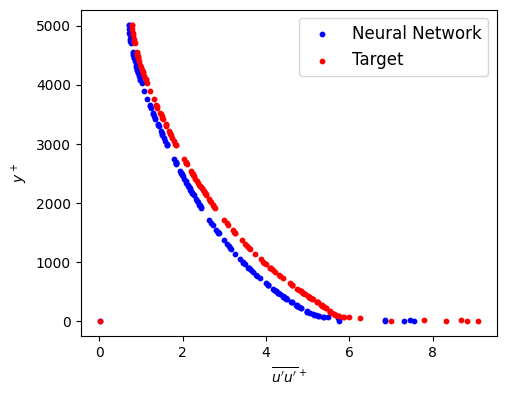

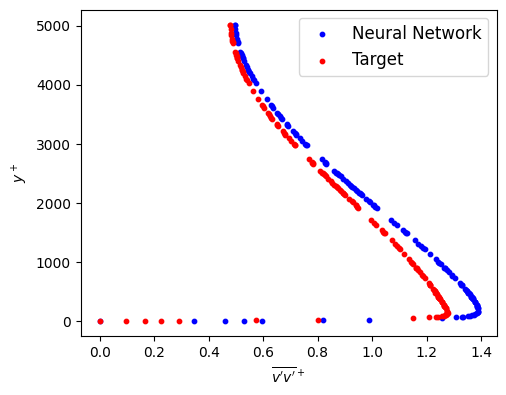

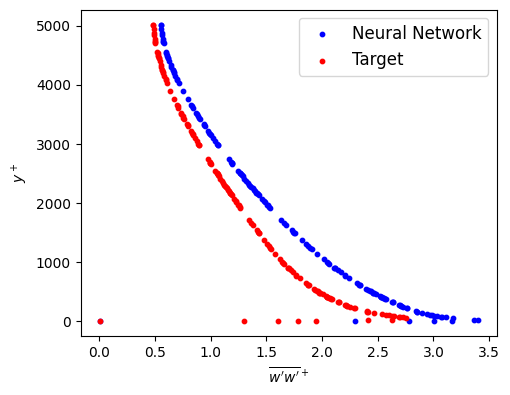

In [40]:
c_NN = y_val_tensor.detach().numpy()

#tau, dudy, k, uu, vv, ww, yplus
ww_NN = ((c_NN[:,0])*(test_var_val[:,0]**2*test_var_val[:,1]**2)/(-6) + 2/3)*test_var_val[:,2]
uu_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_NN[:,0]) + 6*(c_NN[:,1])) + 2/3)*test_var_val[:,2]
vv_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_NN[:,0]) - 6*(c_NN[:,1])) + 2/3)*test_var_val[:,2]


fig1 = plt.figure()
plt.subplots_adjust(left=0.25,bottom=0.20)
plt.scatter(uu_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
plt.scatter(test_var_val[:,3],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
#plt.axis([0, 1.5, 10,5000])
plt.xlabel("$\overline{u'u'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig2 = plt.figure()
plt.subplots_adjust(left=0.25,bottom=0.20)
plt.scatter(vv_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
plt.scatter(test_var_val[:,4],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
#plt.axis([0, 1.5, 10,5000])
plt.xlabel("$\overline{v'v'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig3 = plt.figure()
plt.subplots_adjust(left=0.25,bottom=0.20)
plt.scatter(ww_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
plt.scatter(test_var_val[:,5],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
#plt.axis([0, 1.5, 10,5000])
plt.xlabel("$\overline{w'w'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

plt.show()

0.12654139532085462
0.1712089930196676


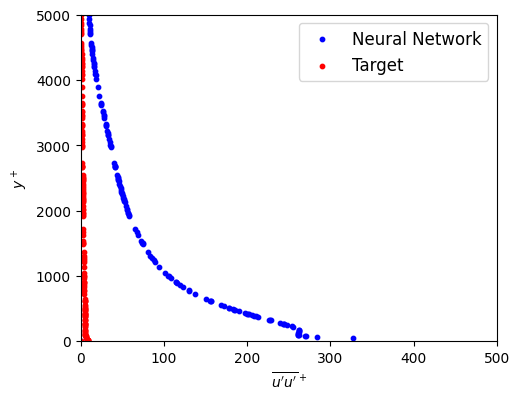

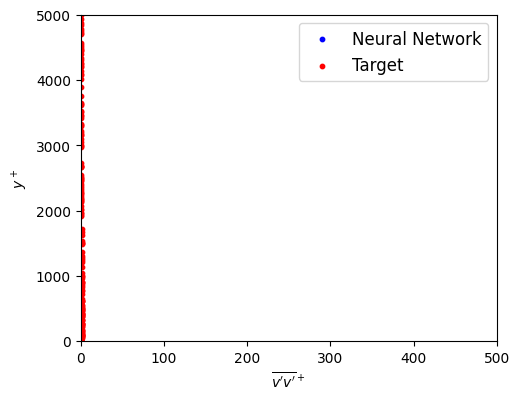

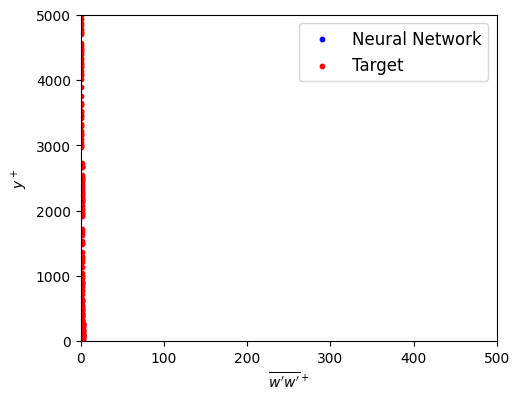

In [49]:
c_NN = y_val_tensor.detach().numpy()

#Not sure how to correctly find mean value, this gives bad results
c_0_NN = np.mean(np.trapz(c_NN[:,0],test_var_val[:,6])/test_var_val[:,6])
c_2_NN = np.mean(np.trapz(c_NN[:,1],test_var_val[:,6])/test_var_val[:,6])

print(c_0_NN)
print(c_2_NN)

#tau, dudy, k, uu, vv, ww, yplus
ww_NN = ((c_0_NN)*(test_var_val[:,0]**2*test_var_val[:,1]**2)/(-6) + 2/3)*test_var_val[:,2]
uu_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_0_NN) + 6*(c_2_NN)) + 2/3)*test_var_val[:,2]
vv_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_0_NN) - 6*(c_2_NN)) + 2/3)*test_var_val[:,2]


fig1 = plt.figure()
plt.subplots_adjust(left=0.25,bottom=0.20)
plt.scatter(uu_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
plt.scatter(test_var_val[:,3],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
plt.axis([0, 500, 0,5000])
plt.xlabel("$\overline{u'u'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig2 = plt.figure()
plt.subplots_adjust(left=0.25,bottom=0.20)
plt.scatter(vv_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
plt.scatter(test_var_val[:,4],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
plt.axis([0, 500, 0,5000])
plt.xlabel("$\overline{v'v'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig3 = plt.figure()
plt.subplots_adjust(left=0.25,bottom=0.20)
plt.scatter(ww_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
plt.scatter(test_var_val[:,5],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
plt.axis([0, 500, 0,5000])
plt.xlabel("$\overline{w'w'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

plt.show()